# BH, Halo Accretion Rates & Occurrence of AGN
## Missy McIntosh, Surhud More, John Silverman
### April-June 2016, IPMU

## Introduction

We investigate two questions: 
1. Does the baryonic accretion rate of black holes in cD galaxies relate to the dark matter halo accretion rate for galaxy clusters? 
2. Does the occurence of AGN relate to the accretion rate of black holes or dark matter halos? 

We begin by matching two photometric catalogs of galaxy RA & Dec locations with a spectroscopic catalog that informs us of the black hole accretion rate for each galaxy. This was done using the best match Sky algorithm in TOPCAT, with a tolerance of 1 arcsecond. The two photometric catalogs vary in dark matter halo accretion rate, so we compare the relation between BH accretion rate and DMH accretion rate between the two. 

We then search for nearby galaxies with spectroscopic data within 10 Mpc of each galaxy in the catalogs. We add the number of satellite galaxies found into bins as a function of radius from the central galaxy. Each spectra is tagged as a Seyfert, Liner, Composite, etc., for each galaxy. We compare the type of galaxy surrounding each galaxy with the galaxy cluster's dark matter halo accretion rate. 

## Method

We convert from RA/DEC in degrees to cartesian coordinates in radians on a unit sphere and then apply a redshift cut based on radial velocity.  We use a KDTree for nearest neighbor matches. We use each photometric galaxy as a central, "seed," galaxy to search in a spherical radius around. We use the default cosmological parameters found in AUM (https://github.com/surhudm/aum/blob/master/README.md) for calculating radii at various redshifts.


In [1]:
import glob
import os
from astropy.io import fits
import sys
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
from tqdm import * 
import cython

%matplotlib inline
%pylab inline
%load_ext Cython
pylab.rcParams['figure.figsize'] = (10, 5);

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
%%cython
import numpy as np
import pandas as pd
from astropy.table import Table
import pyfits
from scipy import spatial
import cosmology as cc
a = cc.cosmology()


def fits_coordinates_to_tree(fits_files):
    '''
    tree, data, df = fits_coordinates_to_tree(fits_file)
    
    Read in tabular fits files to a cKDTree, return list of cartesian coordinates,
    and write out fits Table as a pandas dataframe. 
    '''
    
    df = pd.DataFrame(columns=['RA', 'DEC', 'REDSHIFT', 'BPT','NAME','LAMBDA','FLUX'])
    for fits_file in fits_files:

        hdulist = pyfits.open(fits_file, memmap=True)
        tbdata = hdulist[1].data
        try:
            subset = list(zip(tbdata['RA'], tbdata['DEC'], tbdata['REDSHIFT'], 
                              tbdata['BPT'],tbdata['NAME'],tbdata['LAMBDA'],tbdata['FLUX']))
            df1 = pd.DataFrame(subset, columns=['RA', 'DEC', 'REDSHIFT', 'BPT','NAME','LAMBDA','FLUX'])
        except:
            subset = list(zip(tbdata['RA'], tbdata['DEC'], tbdata['Z_LAMBDA']))
            df1 = pd.DataFrame(subset, columns=['RA', 'DEC', 'REDSHIFT'])
        hdulist.close()

        
        df = pd.concat([df,df1])
        
    df = df.dropna(axis=1, how='all')
        
    coordinates = list(map(tocartesian,df['RA'],df['DEC']))
    tree = spatial.cKDTree(coordinates)
    
    return(tree, coordinates, df)



def tocartesian(ra_in_deg, dec_in_deg):
    """
    (x,y,z) = tocartesian(ra_in_deg, dec_in_deg)
    
    Convert RA and DEC coordinates given 
    in degrees into Cartesian points (x,y,z)
    on unit circle
    """
    
    ra = np.radians(ra_in_deg)
    dec = np.radians(dec_in_deg)
    x = np.cos(ra) * np.cos(dec)
    y = np.sin(ra) * np.cos(dec)
    z = np.sin(dec)
    
    return((x,y,z))


def angular_search_radius(radius_in_mpc,z):
    """
    angular_radius = angular_search_radius(radius_in_mpc,z)
    
    Return the comoving distance as a function of redshift, using default cosmological parameters
    in AUM (https://github.com/surhudm/aum/blob/master/README.md)
    """
    return(radius_in_mpc/a.Dcofz(z))


def redshift_cut(df,angular_matched_indices, z, radial_velocity):
    """
    cut_indices = redshift_cut(df,angular_matched_indices, z, radial_velocity)
    
    Return indices that are constrained by np.abs((C*delta_z)/(1+z)) < radial_velocity
    """
    
    # if there were no angular matches, then there is nothing to cut out
    if len(angular_matched_indices) == 0:
            return([])
        
    # retrieve redshifts for the matched galaxies    
    z_arr = [df.iloc[k]['REDSHIFT'] for k in angular_matched_indices]
    C = 3*10**5 # km/s
    
    # if the cut quantity is less than the radial velocity, keep the galaxy
    cut_mask = []
    for z_i in z_arr:
        delta_z = z - z_i
        cut = np.abs((C*delta_z)/(1+z))
        cut_mask.append(cut < radial_velocity)
    cut_indices = [index for (index, mask) in zip(angular_matched_indices, cut_mask) if mask]
    
    
    # for every few iterations, print out the variables so I can debug
    rand = np.random.binomial(1, 0.001)
    if rand > 0:
        print("for rv {0} and z {4:.2f}, {1}/{2} galaxies are kept; " 
              "last cut value is {3:.2f}, last delz value is {5:.2f}".format(
               radial_velocity, len(cut_indices),len(angular_matched_indices), cut,z, delta_z))
    
    return(cut_indices)



def getdistance(point, point_arr,z):
    """
    dists = getdistance(point, point_arr,z)
    
    Find the distance between two cartesian points on a unit sphere 
    and return it in Mpc using its redshift, using default cosmological parameters
    in AUM (https://github.com/surhudm/aum/blob/master/README.md)
    """
    
    # if there are no points, there is no distance to compute
    if len(point_arr) == 0:
        return([])
    
    # format the array of points and feed into np.lingalg.norm()
    points = np.tile(np.asarray(point), (len(point_arr),1))
    dists = list(map(np.linalg.norm, points - point_arr))
    
    # multiply distance in radians by comoving distance to get it in Mpc
    d_comoving = a.Dcofz(z)
    dists = [d_comoving*d for d in dists]
    
    return(dists)


def getneighbors(seed_df, tree_df, tree_coordinate_list, 
                 tree, mpc_search_radius, radial_velocity_limit):
    """
    indices, distances, types = getneighbors(seed_df, tree_df, tree_coordinate_list, 
                                             tree, mpc_search_radius, radial_velocity_limit)
                 
    Nearest neighbor query for a cKDTree, using a spherical search radius that depends on redshift
    and cosomological parameters, returning index and distance. Also retrieves the surrounding galaxy 
    types listed in the input table. Returns an array of arrays so if you were interested in one central
    galaxy in particular, you could find the surrounding galaxies for that single central galaxy index.
    
    Includes nearest neighbors whose distance is ~0.0
    
    Input
    ------
    seed_df                the pandas dataframe of galaxies you want to search a spherical area around
    tree_df                the pandas dataframe of galaxies populated in your search tree
    tree_coordinate_list   a list of cartesian coordinates for the galaxies populated in your search tree
    tree                   the cKDETree you want to search
    mpc_search_radius      the radius in Mpc for your search sphere around your seed galaxy
    radial_velocity_limit  the radial velocity variance cut (see help(redshift_cut))
    
    Output
    ------
    indices                array of arrays of indicies of the matched galaxies in the tree_df per seed galaxy
    distances              array of arrays of distances of the matched galaxies in the tree_df per seed galaxy
    types                  array of arrays of galaxy types (Seyfert, LINER, etc.) of the matched galaxes
                                                            in the tree_df per seed galaxy
    
    """

    indices = []
    distances = []
    types = []
    for i in np.arange(len(seed_df)):
        
        # select seed/central galaxy to search spherically around
        seed = seed_df.iloc[i]
        seed_z = seed['REDSHIFT']
        try:
            seed_coordinates = tocartesian(seed['RA_1'],seed['DEC_1'])
        except:
            seed_coordinates = tocartesian(seed['RA'],seed['DEC'])
        
        # retrieve angularly matched coordinates in the tree
        # also apply a redshift cut for variance above some radial velocity
        angular_matched_indices = tree.query_ball_point(seed_coordinates,
                                                        angular_search_radius(mpc_search_radius,seed_z))
        redshift_and_angular_matched_indices = redshift_cut(tree_df, 
                                                            angular_matched_indices, 
                                                            seed_z, radial_velocity_limit)
        indices.append(redshift_and_angular_matched_indices)
        
        # retrieve the galaxy type (Seyfert, LINER, etc.) for each galaxy found in the sphere
        galtype = [tree_df.iloc[k]['BPT'] for k in redshift_and_angular_matched_indices]
        types.append(galtype)
        
        # retrieve the distances for each galaxy found in the sphere with respect to the seed galaxy
        matched_tree_coordinate_list = np.asarray([np.array(tree_coordinate_list[x]) 
                                                   for x in redshift_and_angular_matched_indices])
        distances.append(getdistance(seed_coordinates, matched_tree_coordinate_list,seed_z))
        
    return(indices, distances, types)




def strip_nearestneighbors(index, distances, types): 
    """
    index_len, unraveleddistances, unraveledtypes = strip_nearestneighbors(index, distances, types)
    
    Remove the nearest neighbors from index and distances arrays outputted by getneighbors().
    Also flattens/concatenates the array of arrays so you have one long array, 
    if you don't care about the ability to index individual seed/central galaxies
    """
    
    stripped_distances = []
    stripped_indices = []
    stripped_types = []
    
    for i in np.arange(len(distances)):
        x = distances[i]
        y = index[i]
        z = types[i]
        zeros = np.nonzero(x)[0]
        new_x = [x[i] for i in zeros]
        new_y = [y[i] for i in zeros]
        new_types = [z[i] for i in zeros]
        stripped_distances.append(new_x)
        stripped_indices.append(new_y)
        stripped_types.append(new_types)
        
    # flatten array of arrays into one long array
    unraveleddistances = np.concatenate(stripped_distances)
    unraveledtypes = np.concatenate(stripped_types)
    index_len = [len(x) for x in stripped_indices]
    
    return(index_len, unraveleddistances, unraveledtypes)


def get_dists_of_type(string, type_list, distances_list):
    """
    dists = get_dists_of_type(string, type_list, distances_list)
    
    Retrieve the distance for a certain galaxy type (Seyfert, LINER, etc.)
    """
    indices = [i for i, x in enumerate(type_list) if x == string]
    dists = [distances_list[i] for i in indices]
    
    return(dists)


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return(idx) #array[idx]

def retrieve_line_fluxes(which_lines, df_row, j):
    fluxes = []
    for i, line in enumerate(which_lines):
        index = find_nearest(df_row['LAMBDA'],line)
        flux = df_row['FLUX'][index]
        fluxes.append(flux)
        if j < 1:
            print(j, "searched:",line, ', matched:', df_row['NAME'][index],df_row['LAMBDA'][index])
    return(fluxes)

def get_string_set(typelist):
    string_set = list(set(typelist))
        # fix typos in the table
    for i in np.arange(len(typelist)):
        if typelist[i] == 'Star Fo':
            typelist[i] = 'Star Forming'
            
    for i in np.arange(len(typelist)):
        if typelist[i] == 'Composi':
            typelist[i] = 'Composite'
            
    bad_strings=['BLANK        ','             ','Star Fo', 'BLANK','Composi', ' ','']
    for bad_string in bad_strings:
        if bad_string in string_set: 
            string_set.remove(bad_string)
    return(string_set)

In [3]:

# load in spectroscopic table data, place in cKDETree
fits_files = ['portsmouth_emlinekin_full-26.fits','portsmouth_emlinekin_full-DR12-boss.fits']

spec_tree, spec_data, spec_df = fits_coordinates_to_tree(fits_files)

In [34]:
# load in all of the central galaxies with photometric redshifts to search spherically around

__, __, highc_df = fits_coordinates_to_tree(
    ['redmapper_dr8_public_v5.10_catalog.value_added.Z_LAMBDA_0.1_0.33.czl3_highc.fits'])


__, __, lowc_df = fits_coordinates_to_tree(
    ['redmapper_dr8_public_v5.10_catalog.value_added.Z_LAMBDA_0.1_0.33.czl3_lowc.fits'])




In [35]:
#%%prun -r

# find nearest neighbor to spectral galaxies within this radius and for this r.v. limit
mpc_search_radius = 10 # Mpc
radial_velocity_limit = 1800 #km/s #


tree = spec_tree 
tree_df = spec_df
tree_coordinate_list = spec_data

print('searching highc')


highc_indices, highc_distances, highc_types = getneighbors(highc_df, tree_df, tree_coordinate_list,
                                                           tree, mpc_search_radius, radial_velocity_limit)

# get rid of the nearest neighbor matches– we don't want to count the central galaxy itself
highc_num_found,highc_concat_dists, highc_concat_types = strip_nearestneighbors(highc_indices, 
                                                                                highc_distances,highc_types)

print('searching lowc')

lowc_indices, lowc_distances, lowc_types = getneighbors(lowc_df,tree_df, tree_coordinate_list,
                                                        tree, mpc_search_radius, radial_velocity_limit)

lowc_num_found,lowc_concat_dists, lowc_concat_types = strip_nearestneighbors(lowc_indices,
                                                                             lowc_distances,lowc_types)

print('all done')

searching highc
for rv 1800 and z 0.32, 6/198 galaxies are kept; last cut value is 53545.49, last delz value is -0.24
for rv 1800 and z 0.26, 8/321 galaxies are kept; last cut value is 44605.42, last delz value is -0.19
for rv 1800 and z 0.29, 3/285 galaxies are kept; last cut value is 10289.06, last delz value is 0.04
for rv 1800 and z 0.30, 18/287 galaxies are kept; last cut value is 43435.36, last delz value is -0.19
searching lowc
for rv 1800 and z 0.12, 188/1930 galaxies are kept; last cut value is 94999.84, last delz value is -0.35
for rv 1800 and z 0.25, 15/438 galaxies are kept; last cut value is 44532.76, last delz value is 0.19
for rv 1800 and z 0.27, 11/303 galaxies are kept; last cut value is 33576.58, last delz value is -0.14
for rv 1800 and z 0.26, 1/300 galaxies are kept; last cut value is 36704.35, last delz value is -0.15
for rv 1800 and z 0.33, 6/282 galaxies are kept; last cut value is 38325.39, last delz value is 0.17
for rv 1800 and z 0.32, 11/295 galaxies are kept

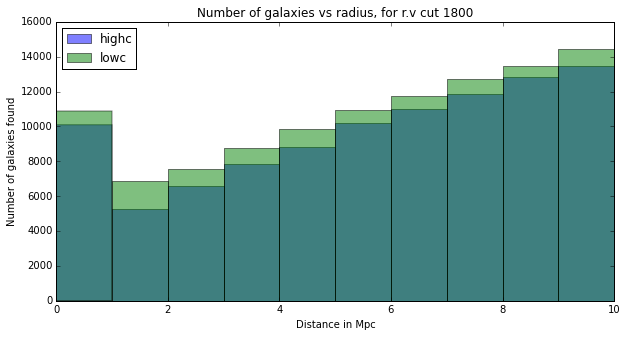

In [36]:

# number of gal as function of radius
plt.figure(figsize=(10,5))
plt.title('Number of galaxies vs radius, for r.v cut {0}'.format(radial_velocity_limit))
plt.hist(highc_concat_dists, alpha=0.5, width=1, label="highc")
plt.hist(lowc_concat_dists, alpha=0.5, width=1, label="lowc")
plt.xlabel('Distance in Mpc')
plt.ylabel('Number of galaxies found')
plt.legend(loc=2)
plt.show()

In [ ]:
if show_bar:    
        # stacked bar graph
        bar_arr = np.asarray(bar_arr)
        bottom = np.cumsum(bar_arr, axis=0)
        barplot = plt.figure(1)
        ax = barplot.add_subplot(111)
        color=iter(cm.rainbow(np.linspace(0.1,1,16)))

        for i in np.arange(len(bar_arr)):
            string = string_set[i]
            data = np.asarray(bar_arr[i])
            c=next(color)


            if log:
                index = bins
                w = index/(10*np.log10(number_of_bins))
                align = 'center'
                if width >0:
                    #index = index + np.log10(2)
                    align = 'edge'
                    w = index/(20*np.log10(number_of_bins))


            else:
                index = np.arange(1,number_of_bins+2)+width
                w = 0.45
                align= 'center'


            if i > 0:
                plt.bar(index, data, width=w, alpha=opacity, \
                        label='{0}, {1}'.format(string,dataset), color=c, bottom = bottom[i-1], align=align,log=log)

            else:
                plt.bar(index, data, width=w,alpha=opacity, \
                        label='{0}, {1}'.format(string,dataset), color=c, align=align, log=log)

        plt.title('highc vs lowc',fontsize=20)
        plt.ylabel("Fraction of surrounding galaxies", fontsize=14)
        plt.xlabel("Distance, in Mpc", fontsize=14)
        #ticks = np.arange(index.min(), index.max(), 10)
        #ax.set_xticklabels(np.round(np.arange(0,10,tmp[1])))
        #plt.xlim(-10,100)
        if log:
            plt.xscale('log')
            plt.xlim(-2,number_of_bins+1)
        else:
            plt.xlim(1,number_of_bins+2)
            plt.ylim(0,1)
            #ax.set_xticklabels(np.arange(-1,number_of_bins,2))

        #barplot.set_size_inches(20, 10.5)
        plt.legend(bbox_to_anchor=(1.27, 1))

[69232.400244974473, 7410.6143448970988, 5339.308293681519, 3602.4524466244111, 2217.157622230663, 1145.0164268613778, 558.26217928993094, 410.14497282930984, 311.42954022905212, 240.25585768061916]
[74134.372492204842, 10374.860082855939, 6077.313646774518, 3678.5605969052085, 1738.0858070346542, 784.29455044901351, 454.85254071005113, 363.36359331890361, 282.63008485515132, 226.13952794573942]
[143366.7727371793, 17785.474427753037, 11416.621940456038, 7281.0130435296196, 3955.2434292653174, 1929.3109773103913, 1013.1147199999822, 773.50856614821339, 594.05962508420339, 466.39538562635857]


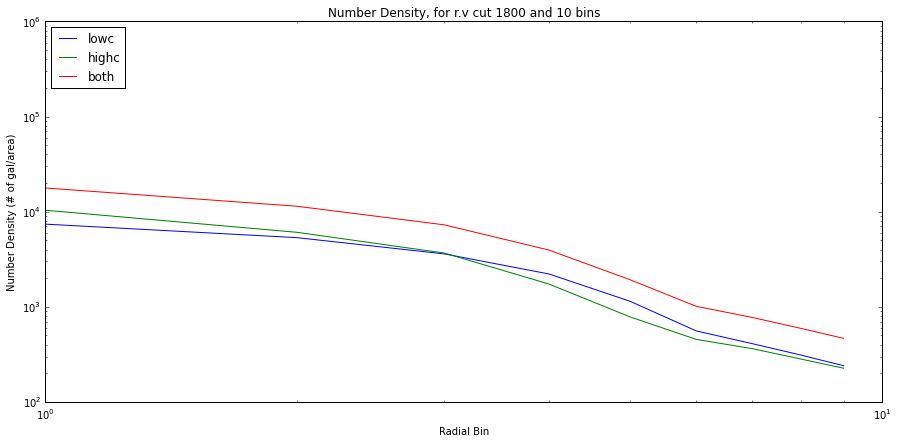

In [37]:
'''


# number density gal as function of radius
Could you please also plot the surface density of
each of the galaxies as a function of the projected number around the
central galaxies please?

So basically: N/(pi (R_2^2-R_1^2)

where R_1 and R_2 are the inner and outer radius of the different annuli.
'''

number_of_bins = 10

plt.figure(figsize=(10,5))
fig = pyplot.figure()
ax = fig.add_subplot(2,1,1)
plt.title('Number Density, for r.v cut {0} and {1} bins'.format(radial_velocity_limit, number_of_bins))

for dataset in ['lowc', 'highc', 'both']:

    if dataset == 'lowc':
        typelist = list(lowc_concat_types)
        distlist = lowc_concat_dists
        width=-0.2
        opacity = 0.4
        symb =':'
    elif dataset == 'highc': 
        width = 0.2
        typelist = list(highc_concat_types)
        distlist = highc_concat_dists
        opacity = 0.9
        symb = '--'
    else:
        typelist = list(highc_concat_types) + list(lowc_concat_types)
        distlist = np.concatenate((highc_concat_dists, lowc_concat_dists))
        opacity = 1
        symb = '-'
        

    string_set = get_string_set(typelist)


    bins = np.logspace(-1., 1., number_of_bins)
    #bins = np.linspace(0, number_of_bins, number_of_bins)

    data_arr = [np.asarray(get_dists_of_type(string, typelist, distlist)) for string in string_set]
    which_bins = numpy.digitize(np.concatenate(data_arr), bins)
    total_count = np.bincount(which_bins)


    bins = np.concatenate([[0], bins])
    number_density = []
    for i in np.arange(len(bins)-1):
        j = i+1
        number = total_count[i]
        area = np.pi*(bins[j]**2-bins[i]**2)
        number_density.append(number/area)

    print(number_density)


    
    plt.loglog(number_density, label=dataset)
    
plt.xlabel('Radial Bin')
#ax.set_xscale('log')
plt.ylabel('Number Density (# of gal/area)')
plt.legend(loc=2)

plt.show()


We then plot the radius vs the fractional type of galaxies found for each of the galaxies with spectral data.

Binning Info:  DescribeResult(nobs=10, minmax=(415, 48353), mean=9825.7000000000007, variance=227862717.12222227, skewness=1.9063645321661835, kurtosis=2.3645516664028934)
Binning Info:  DescribeResult(nobs=10, minmax=(581, 45512), mean=8983.0, variance=201118819.77777779, skewness=1.9607586877291383, kurtosis=2.5435124630086925)
Binning Info:  DescribeResult(nobs=10, minmax=(996, 93865), mean=18808.700000000001, variance=856897880.45555556, skewness=1.9336021689906433, kurtosis=2.453038003417518)


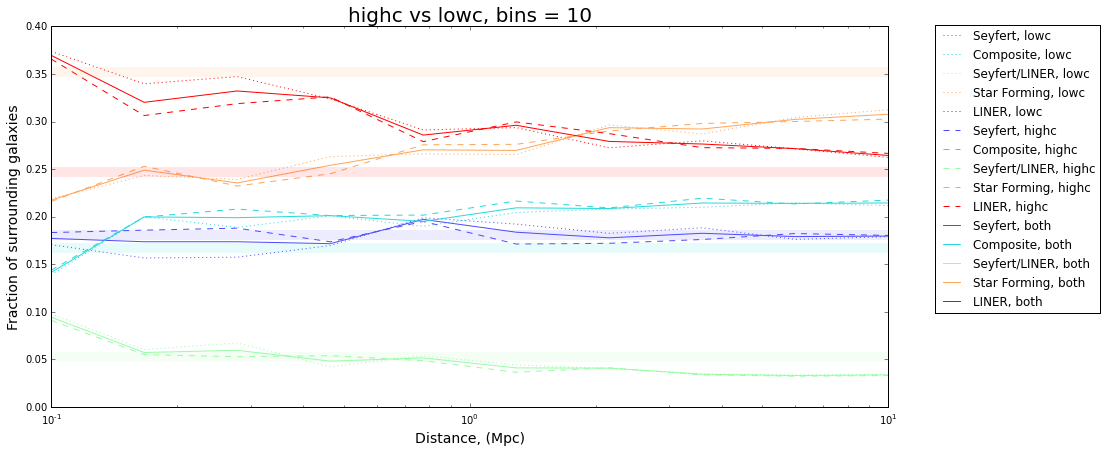

In [38]:
# plot how many galaxies we found of each type as a fraction of the total galaxies found in each radial bin 
# per input catalog

# shown in bar and line plot, with logscale toggle

show_bar = True
show_line = True
log = True
number_of_bins = 10#radius


# line graph
lineplot = plt.figure(2)
line_graph = pyplot.figure(2)
ax = line_graph.add_subplot(2,1,1)
plt.title('highc vs lowc, bins = {0}'.format(number_of_bins), fontsize=20)
plt.ylabel("Fraction of surrounding galaxies", fontsize=14)
plt.xlabel("Distance, (Mpc)", fontsize=14)
if log:
    ax.set_xscale('log')
    #plt.xlim(0,number_of_bins)
    #plt.ylim(-0.01,0.4)
else:
    plt.xlim(0,number_of_bins)
    #ax.set_xticklabels(np.arange(-1,number_of_bins,2))

for dataset in ['lowc', 'highc', 'both']:

    if dataset == 'lowc':
        typelist = list(lowc_concat_types)
        distlist = lowc_concat_dists
        width=-0.2
        opacity = 0.4
        symb =':'
    elif dataset == 'highc': 
        width = 0.2
        typelist = list(highc_concat_types)
        distlist = highc_concat_dists
        opacity = 0.9
        symb = '--'
    else:
        typelist = list(highc_concat_types) + list(lowc_concat_types)
        distlist = np.concatenate((highc_concat_dists, lowc_concat_dists))
        opacity = 1
        symb = '-'
    
        
        
    
    #print(dataset,len(typelist),len(distlist), string_set)
    
    string_set = get_string_set(typelist)
    
    
    # get total in each bin then weight by that
    
    if log:
        bins = np.logspace(-1., 1., number_of_bins)
    else:
        bins = np.linspace(0, number_of_bins, number_of_bins)
    
    data_arr = [np.asarray(get_dists_of_type(string, typelist, distlist)) for string in string_set]
    which_bins = numpy.digitize(np.concatenate(data_arr), bins)
    total_count = np.bincount(which_bins)
    print('Binning Info:  {0}'.format(scipy.stats.describe(total_count)))
    
    bar_arr = []
    for i in np.arange(len(data_arr)):
        digitized = np.bincount(np.digitize(data_arr[i], bins))
        bar_data = [digitized[i]/total_count[i] for i in np.arange(len(total_count))]
        bar_arr.append(bar_data)


    colors = cm.rainbow(np.linspace(0.1,1,len(string_set)))
    color_dict= dict(zip(string_set, colors))
    
    
    for i in np.arange(len(bar_arr)):
        string = string_set[i]
        data = np.asarray(bar_arr[i])
        c=color_dict[string]
        plt.plot(bins, data, label = '{0}, {1}'.format(string,dataset), color =c, linestyle=symb, markersize=10)
        
    # add lines for how many of each type exist in the overall data set
    if dataset == 'both':
        freq = [tree_df.groupby('BPT')['BPT'].count()[string] for string in string_set]
        type_freq = list(zip(string_set, freq/np.sum(freq)))
        color=iter(cm.rainbow(np.linspace(0.1,1,10)))
        for (string,freq) in type_freq:
            c=color_dict[string]
            plt.axhline(y=freq, color=c, linestyle=symb, alpha=0.1, linewidth=10)
    
    
plt.legend(bbox_to_anchor=(1.26, 1.02))
plt.show()
plt.close()

In [ ]:
matplotlib.pyplot.close("all")

In [4]:
lines = [5007,4861,6583,6562] 
fluxes = [retrieve_line_fluxes(lines, row, index) for index, row in spec_df.iterrows()]
print(np.shape(fluxes))
O3,HBeta, N2, HAlpha = [np.asarray(flux) for flux in zip(*fluxes)]
print("all done")

'''
For some reason there are two entries of line fluxes per each entry in the dataframe. 
I'm using both here, but I'm not sure of the difference.

'''

(0, 'searched:', 5007, ', matched:', '[OIII]', 5006.77)
(0, 'searched:', 4861, ', matched:', 'Hb', 4861.3198)
(0, 'searched:', 6583, ', matched:', '[NII]', 6583.3398)
(0, 'searched:', 6562, ', matched:', 'Ha', 6562.7998)
(0, 'searched:', 5007, ', matched:', '[OIII]', 5006.77)
(0, 'searched:', 4861, ', matched:', 'Hb', 4861.3198)
(0, 'searched:', 6583, ', matched:', '[NII]', 6583.3398)
(0, 'searched:', 6562, ', matched:', 'Ha', 6562.7998)
(2440798, 4)
all done


In [5]:
type_list = spec_df['BPT'].values
x = np.log10(N2/HAlpha)
y = np.log10(O3/HBeta)

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


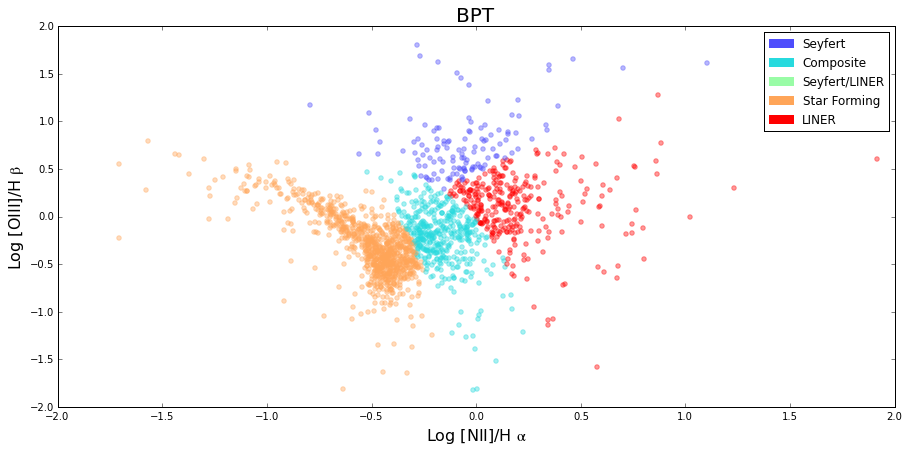

In [33]:
string_set = get_string_set(type_list)
bad_strings =['BLANK        ','             ','Star Fo', 'BLANK','Composi', ' ','']


colors = cm.rainbow(np.linspace(0.1,1,len(string_set)))
color_dict= dict(zip(string_set, colors))
#color_arr = [color_dict[t] for t in type_list]


fig = pyplot.figure()
ax = fig.add_subplot(2,1,1)
plt.title("BPT", fontsize=20)
plt.rc('text', usetex=False)
plt.rcParams['mathtext.default']='regular'

plt.ylabel(r'Log [OIII]/H ${\beta}$', fontsize=16)
plt.xlabel(r'Log [NII]/H ${\alpha}$', fontsize=16)



for i in tqdm(range(int(len(x)/1000))):

    type_to_plot = type_list[i]
    if type_to_plot in bad_strings:
        continue
    
        
    ax.scatter(x[i],y[i], color=color_dict[type_list[i]], alpha=0.4)

import matplotlib.patches as mpatches
proxy_arr = []
for string in string_set:
    color=color_dict[string]
    proxy = mpatches.Patch(color=color, label=string)
    #Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=color, label=i)
    proxy_arr.append(proxy)

plt.xlim(-2, 2)
plt.ylim(-2, 2)


plt.legend(handles=np.asarray(proxy_arr))
plt.show()
#ax.legend(handles, labels)

In [8]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap, extent=extent)
plt.show()

ValueError: cannot convert float NaN to integer

In [25]:
# why are none of the seyfert/liners plotting? 

indices = [i for i, x in enumerate(type_list) if x == 'Seyfert/LINER']
y1 = [y[i] for i in indices]
x1 = [x[i] for i in indices]
print(len(x1))

x1_arr = []
y1_arr = []

for i in np.arange(len(x1)):
    #if not np.isnan(x1[i]) and not np.isinf(x1[i]):
    if not np.isnan(y1[i]) and not np.isinf(y1[i]):
        x1_arr.append(x1[i])
        y1_arr.append(y1[i])
print(np.shape(x1_arr), np.shape(y1_arr))

(0,) (0,)


In [ ]:
'''


# load in the spectroscopic table data matched with the photometric data in TOPCAT

df1 = pd.read_csv('highc_and_26_bestmatch.csv', delimiter=',',index_col=False, header=0)
df2 = pd.read_csv('highc_and_DR12-boss_bestmatch.csv', delimiter=',',index_col=False, header=0)
df = pd.concat([df1,df2])
highc_df = df


df1 = pd.read_csv('lowc_and_26_bestmatch.csv', delimiter=',',index_col=False, header=0)
df2 = pd.read_csv('lowc_and_DR12-boss_bestmatch.csv', delimiter=',',index_col=False, header=0)
df = pd.concat([df1,df2])
lowc_df = df
'''